# Amazon Deforestation Forecasting Using AI/ML and IoT Data
## AAI-530 Team 8 Final Project

Team 8:  Tyler Foreman

University of San Diego, Applied Artificial Intelligence

Date:  Feburary 11, 2023

GitHub Repository: https://github.com/t4ai/amazon-deforestation-forecasting

In [3]:
# install necessary libraries
!pip install geopandas

In [4]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from shapely.geometry import Point, shape
from shapely.geometry import Point, LineString, Polygon, MultiPoint

## Exploratory Data Analysis

Load geospatial shape files and evaluate.  Objectives are:

1.  Interrogate time series layer: yearly_deforsestation_biome
2.  Visualize the time series layer
3.  Check for mising values
4.  Evaluate value ranges of target variable
5.  Interrogate supporting layers and determine how to create normalized analytical dataset


In [5]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Load geo data layers
root_dir = '/content/drive/MyDrive/USD/datasets/amazon_deforestation'
geo_yearly_deforestation_biome = gpd.read_file(root_dir + '/yearly_deforestation_biome/yearly_deforestation_biome.shp')

In [7]:
geo_states_amazon_biome = gpd.read_file(root_dir + '/states_amazon_biome/states_amazon_biome.shp')

In [8]:
geo_hydrography_biome = gpd.read_file(root_dir + '/hydrography_biome/hydrography_biome.shp')

In [9]:
geo_no_forest_biome = gpd.read_file(root_dir + '/no_forest_biome/no_forest_biome.shp')

### Interrogate the time series data layer

In [10]:
# display some samples
geo_yearly_deforestation_biome.sample(5)

,fid,state,path_row,main_class,class_name,def_cloud,julian_day,image_date,year,area_km,scene_id,source,satellite,sensor,uuid,geometry
257389,600094,MT,22866,DESMATAMENTO,d2017,0.0,238,2017-08-26,2017.0,0.064774,100638.0,None,None,None,a6bef3f6-0016-409c-bd3a-431d4059b0ea,"POLYGON ((-56.93537 -9.44183, -56.93537 -9.441..."
466190,118997,PA,22562,DESMATAMENTO,d2015,0.0,196,2015-07-15,2015.0,1.050656,2573.0,None,None,None,dacf0e3d-0999-4656-a70e-1a79d2008477,"POLYGON ((-50.78647 -3.29703, -50.78646 -3.297..."
469818,123035,PA,22464,DESMATAMENTO,d2016,2015.0,253,2015-09-10,2016.0,0.038963,100010.0,None,None,None,c581eda5-7379-4922-81a1-4bc0badae8d6,"POLYGON ((-49.65735 -5.18161, -49.65735 -5.181..."
4584,331319,AM,22963,DESMATAMENTO,d2015,0.0,240,2015-08-28,2015.0,0.074977,2638.0,None,None,None,6ed2252c-dffc-40ea-b445-6b7d8854b6bf,"POLYGON ((-58.18926 -3.67343, -58.18619 -3.673..."
476521,129800,PA,22364,DESMATAMENTO,d2016,0.0,41,2016-02-10,2016.0,0.188131,100178.0,None,None,None,43ed838c-8b12-4299-9b02-89bbe2ff458c,"POLYGON ((-49.47990 -5.28450, -49.47988 -5.284..."


In [11]:
# print descriptive statistics
geo_yearly_deforestation_biome.describe()

,fid,def_cloud,julian_day,year,area_km,scene_id
count,666304.000000,510630.000000,666304.000000,666304.000000,666304.000000,665727.000000
mean,333152.500000,321.841846,219.746364,2015.468742,0.174381,20848.936883
std,192345.541219,737.740580,32.035579,4.530961,0.550267,39564.416673
min,1.000000,0.000000,1.000000,2008.000000,0.000000,1.000000
25%,166576.750000,0.000000,207.000000,2011.000000,0.065143,804.000000
50%,333152.500000,0.000000,219.000000,2016.000000,0.090982,1401.000000
75%,499728.250000,0.000000,233.000000,2019.000000,0.153751,2559.000000
max,666304.000000,2021.000000,363.000000,2022.000000,123.475783,101293.000000


In [12]:
#check data types
geo_yearly_deforestation_biome.dtypes

fid              int64
state           object
path_row        object
main_class      object
class_name      object
def_cloud      float64
julian_day       int64
image_date      object
year           float64
area_km        float64
scene_id       float64
source          object
satellite       object
sensor          object
uuid            object
geometry      geometry
dtype: object

In [13]:
# convert image_date to datetime
geo_yearly_deforestation_biome['image_date'] = pd.to_datetime(geo_yearly_deforestation_biome['image_date'])

In [14]:
# visualize the area_km total by year
yearly_deforestation = geo_yearly_deforestation_biome.groupby(pd.Grouper(key="image_date", freq="1Y")).sum()
yearly_deforestation['image_date'] = yearly_deforestation.index

<ipython-input-14-39dba510b50c>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  yearly_deforestation = geo_yearly_deforestation_biome.groupby(pd.Grouper(key="image_date", freq="1Y")).sum()


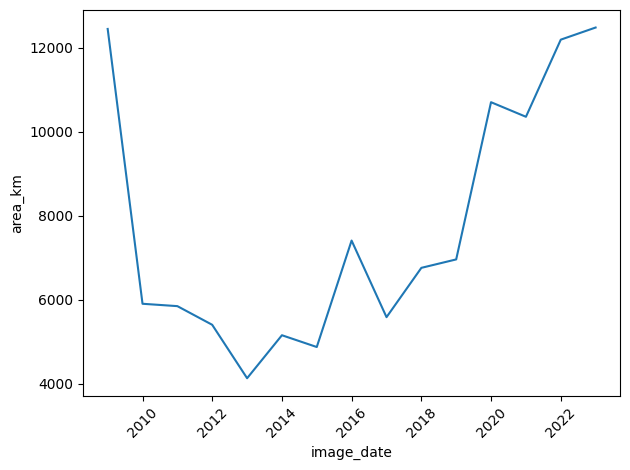

In [15]:
# line plot
sns.lineplot(x="image_date", y="area_km", data=yearly_deforestation)
plt.xticks(rotation=45)
plt.tight_layout()

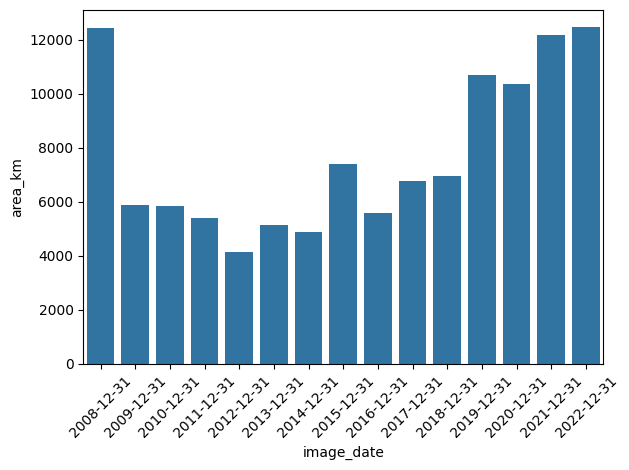

In [16]:
# show as bar graph
sns.barplot(x="image_date", y="area_km", data=yearly_deforestation)
plt.xticks(rotation=45)
plt.tight_layout()

In [17]:
# visualize the area_km total by state by year
state_deforestation = geo_yearly_deforestation_biome.groupby(['state', pd.Grouper(key="image_date", freq="1Y")]).sum()

<ipython-input-17-ad7e65832fbe>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  state_deforestation = geo_yearly_deforestation_biome.groupby(['state', pd.Grouper(key="image_date", freq="1Y")]).sum()


In [18]:
state_deforestation

fid  def_cloud  julian_day       year     area_km  \
state image_date                                                            
AC    2008-12-31  826890113   303057.0      629500  5433648.0  288.792419   
      2009-12-31  518115260     8031.0      423648  3471552.0  161.738798   
      2010-12-31  813567682  1018516.0      577216  5374740.0  265.366641   
      2011-12-31  924697382    68333.0      688288  6149638.0  295.785591   
      2012-12-31  760215623   249362.0      546148  5176876.0  270.534694   
...                     ...        ...         ...        ...         ...   
TO    2018-12-31   16060203        0.0       10505   104936.0    4.760367   
      2019-12-31   19752636     2018.0       16298   147387.0    9.619698   
      2020-12-31   23576626        0.0       16767   149480.0   10.115500   
      2021-12-31   23891082        0.0       16586   147533.0   11.300232   
      2022-12-31   70207011        0.0       35250   299256.0   16.442140   

                   scene_id  
state image_date             
AC    2008-12-31  1758175.0  
      2009-12-31  1536732.0  
      2010-12-31  3008895.0  
      2011-12-31  3960568.0  
      2012-12-31  4032307.0  
...                     ...  
TO    2018-12-31  5256270.0  
      2019-12-31     4196.0  
      2020-12-31    48622.0  
      2021-12-31    81571.0  
      2022-12-31   232259.0  

[135 rows x 6 columns]

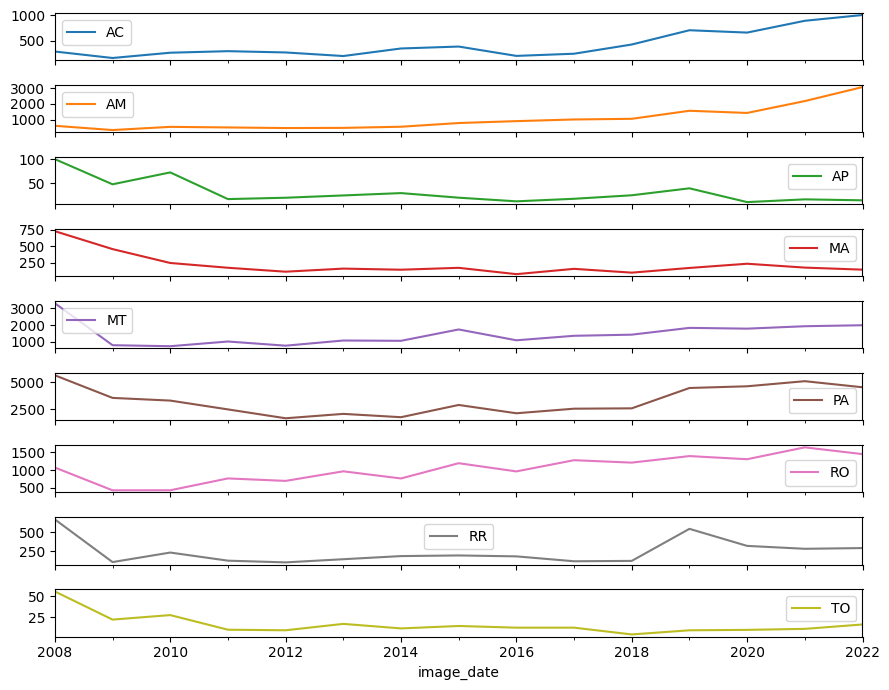

In [19]:
# plot by state
ax = state_deforestation.unstack(level=0).plot(kind='line', y='area_km', subplots=True, rot=0, figsize=(9, 7))
plt.tight_layout()

### Interrogate the supporting metadata layers

In [20]:
# check states metadata
geo_states_amazon_biome.sample(5)

,id,nome,sigla,geocodigo,geometry
0,2,Rondônia,RO,11,"MULTIPOLYGON (((-59.98861 -11.91000, -59.98811..."
1,3,Acre,AC,12,"POLYGON ((-66.62735 -9.89885, -66.62730 -9.899..."
7,14,Mato Grosso,MT,51,"MULTIPOLYGON (((-50.35017 -9.83338, -50.35059 ..."
6,8,Tocantins,TO,17,"POLYGON ((-47.89974 -5.25030, -47.89995 -5.250..."
4,6,Pará,PA,15,"MULTIPOLYGON (((-46.38414 -1.03655, -46.38429 ..."


In [21]:
# check hydrography metadata
geo_hydrography_biome.sample(5)

,fid,state,path_row,main_class,class_name,def_cloud,julian_day,image_date,year,area_km,scene_id,source,satellite,sensor,uuid,geometry
9557,9397,AM,23261,HIDROGRAFIA,HIDROGRAFIA,0.0,0.0,None,2007.0,0.712036,0.0,None,None,None,893e4b47-0394-47ef-928e-1ccc618296fd,"POLYGON ((-61.31780 -2.21542, -61.31673 -2.215..."
7244,7073,AM,00461,HIDROGRAFIA,HIDROGRAFIA,0.0,0.0,None,2007.0,0.000000,0.0,None,None,None,a19c5c65-7220-4a4a-a498-bfa7ffb925ce,None
22311,22243,PA,22759,HIDROGRAFIA,HIDROGRAFIA,0.0,0.0,None,2007.0,0.046275,0.0,None,None,None,8e43c30f-f26f-410b-9bbf-b86540150d00,"POLYGON ((-54.20060 1.64796, -54.20006 1.64796..."
19444,19347,MA,22261,HIDROGRAFIA,HIDROGRAFIA,0.0,0.0,None,2007.0,0.063761,0.0,None,None,None,06a2048f-6377-49b8-a53d-2e884accba6d,"POLYGON ((-45.66870 -1.24756, -45.67088 -1.247..."
9017,8856,AM,00162,HIDROGRAFIA,HIDROGRAFIA,0.0,0.0,None,2007.0,0.060496,0.0,None,None,None,e16cc800-6e43-4b38-a549-74607574fae7,"POLYGON ((-65.20686 -2.82743, -65.20686 -2.826..."


In [22]:
# check metadata of areas with no forest
geo_no_forest_biome.sample(5)

,fid,state,path_row,main_class,class_name,def_cloud,julian_day,image_date,year,area_km,scene_id,source,satellite,sensor,uuid,geometry
10363,9910,MT,22867,NAO_FLORESTA,NAO_FLORESTA,0.0,0.0,None,2007.0,28.710555,0.0,None,None,None,b56c9b31-02ce-44c6-8543-49f6538ce194,"POLYGON ((-57.62437 -10.32150, -57.62130 -10.3..."
6254,5768,PA,22566,NAO_FLORESTA,NAO_FLORESTA2,0.0,0.0,None,2007.0,0.022931,0.0,None,None,None,a504a2f3-eb45-484a-be66-ae13992a9183,"POLYGON ((-51.83996 -8.13615, -51.83834 -8.136..."
7924,7484,PA,22866,NAO_FLORESTA,NAO_FLORESTA2,0.0,0.0,None,2007.0,0.077603,0.0,None,None,None,12a5baed-8349-437d-a442-58b2390fc56f,"POLYGON ((-56.39009 -8.18564, -56.38955 -8.185..."
3346,2847,MA,22162,NAO_FLORESTA,NAO_FLORESTA,0.0,0.0,None,2007.0,0.035566,0.0,None,None,None,33239a5d-e2e4-46f7-812f-3d2756f7b4a6,"POLYGON ((-44.74364 -3.42431, -44.74149 -3.424..."
46930,46784,AP,22858,NAO_FLORESTA,NAO_FLORESTA2,0.0,0.0,None,2007.0,0.128148,0.0,None,None,None,d5a72823-b36e-40dd-94bf-d30aa5dbf32e,"POLYGON ((-54.72999 2.42994, -54.72784 2.42994..."


### Hydrography and No Forest layers appear to have some time element, investigate these further

In [23]:
# start with hydrography
geo_hydrography_biome.describe()

,fid,def_cloud,julian_day,year,area_km,scene_id
count,32017.000000,31951.0,31951.0,31951.0,32017.000000,31951.0
mean,16009.000000,0.0,0.0,2007.0,3.411629,0.0
std,9242.656121,0.0,0.0,0.0,75.965504,0.0
min,1.000000,0.0,0.0,2007.0,0.000000,0.0
25%,8005.000000,0.0,0.0,2007.0,0.005568,0.0
50%,16009.000000,0.0,0.0,2007.0,0.067546,0.0
75%,24013.000000,0.0,0.0,2007.0,0.234795,0.0
max,32017.000000,0.0,0.0,2007.0,5616.250641,0.0


For hydrography, analysis shows that all of the data was collected in 2007, so just need to group and sum by state.

There appear to be some data gaps, so will need to do some cleanup potentially of this data.

In [24]:
# start with hydrography
geo_no_forest_biome.describe()

,fid,def_cloud,julian_day,year,area_km,scene_id
count,52528.000000,51942.0,51942.0,51942.0,52528.000000,51942.0
mean,26264.500000,0.0,0.0,2007.0,5.324204,0.0
std,15163.671807,0.0,0.0,0.0,131.468175,0.0
min,1.000000,0.0,0.0,2007.0,0.000000,0.0
25%,13132.750000,0.0,0.0,2007.0,0.033840,0.0
50%,26264.500000,0.0,0.0,2007.0,0.092565,0.0
75%,39396.250000,0.0,0.0,2007.0,0.285425,0.0
max,52528.000000,0.0,0.0,2007.0,18363.179058,0.0


No forest data is also all collected in 2007, so will group by state.

There appear to be some data gaps, so will need to do some cleanup potentially of this data.

## Data Cleanup and Preparation

Clean up the dataset and prepare for modeling.  Objectives are:

1.  Remove empty values
2.  Remove columns we do not need
3.  Summarize supporting datasets to state and year
4.  Merge dataset features from supporting datasets to time-series
5.  Normalize values
6.  One-hot encode categorical values


### Start cleanup of supporting layers
Cleanup and consolidate hydrography and no forest layers

<Axes: >

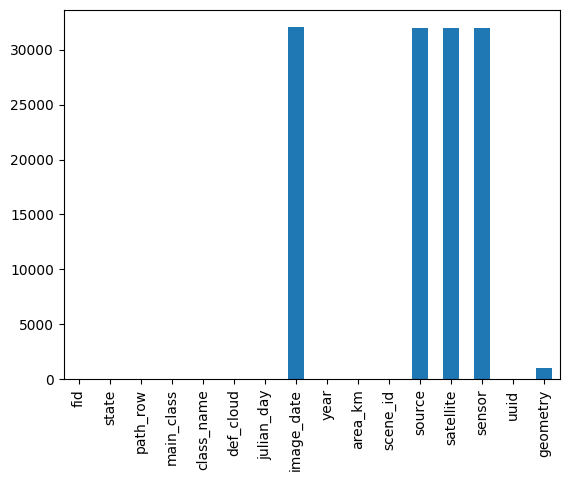

In [25]:
# visualize missing data
geo_hydrography_biome.isna().sum().plot.bar()

For hydrography layer, there are missing values but they are not relevant to our analysis.  We will drop columns we do not need.

---



In [26]:
# drop unnecessary columns
geo_hydrography_clean = geo_hydrography_biome.drop(['main_class', 'class_name', 'def_cloud', 'julian_day', 'image_date', 'scene_id', 'source', 'satellite', 'sensor'], axis=1)


In [27]:
geo_hydrography_clean.sample(5)

,fid,state,path_row,year,area_km,uuid,geometry
17663,17539,PA,22765,2007.0,8.920705e-02,e93181a5-0cef-4f80-a550-91a0f84160e0,"POLYGON ((-55.35955 -7.51906, -55.35740 -7.519..."
17860,17732,AM,23060,2007.0,2.400095e-02,4040fe52-911b-4b03-8e99-2445c5113a7a,"POLYGON ((-59.24193 -0.25353, -59.24189 -0.253..."
1338,1109,PA,22261,2007.0,1.839877e-02,f73e81c9-fd60-46b1-a0f8-ed100ecda040,"POLYGON ((-46.48815 -0.87553, -46.48972 -0.875..."
5182,5100,AM,00664,2007.0,1.019600e-11,788bc641-8d82-4473-833b-a451541f430e,"POLYGON ((-73.24352 -6.10290, -73.24352 -6.102..."
21053,20958,AM,00460,2007.0,0.000000e+00,f8ad69a3-5a97-4365-9f50-1731e0807ff1,None


In [28]:
# roll up total area to the state level
geo_hydrography_state = geo_hydrography_clean.groupby(['state'])['area_km'].sum()

In [29]:
geo_hydrography_state.sample(9)

state
TO      395.633885
RO     1766.086970
AP     3461.356696
RR     1753.155361
AM    51077.536558
AC      113.339475
MT     1728.346000
PA    44115.717775
MA     4818.959857
Name: area_km, dtype: float64

<Axes: >

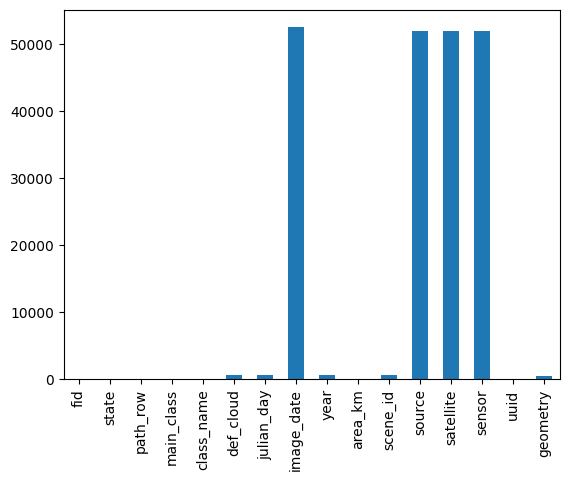

In [30]:
# visualize missing data
geo_no_forest_biome.isna().sum().plot.bar()

For no_forest layer, there are missing values but they are not relevant to our analysis.  We will drop columns we do not need.

In [31]:
# drop unnecessary columns
geo_noforest_clean = geo_no_forest_biome.drop(['main_class', 'class_name', 'def_cloud', 'julian_day', 'image_date', 'scene_id', 'source', 'satellite', 'sensor'], axis=1)

In [32]:
geo_noforest_clean.sample(5)

,fid,state,path_row,year,area_km,uuid,geometry
4103,3604,MA,22161,2007.0,0.169191,8aa457d2-cda0-46a1-a548-fb7415abcead,"POLYGON ((-44.97417 -1.27500, -44.96825 -1.275..."
43624,43445,RO,22968,2007.0,30.184567,2780d36c-5a86-457a-92e1-b8e7981b42ba,"POLYGON ((-60.08077 -12.08157, -60.08050 -12.0..."
34985,34802,MT,22770,2007.0,0.270828,434330c1-85de-41bc-ac39-15fd4d7a6b2f,"POLYGON ((-57.28909 -13.68642, -57.28748 -13.6..."
24723,24376,AM,23359,2007.0,0.042747,20e9497e-b0fd-4f41-bcce-95d9703e8c63,"POLYGON ((-63.28378 1.01308, -63.28324 1.01308..."
41971,41787,PA,22965,2007.0,1.951867,8f0b6449-9d65-4bfb-8d84-18ce569bd184,"POLYGON ((-58.00304 -6.89767, -58.00049 -6.897..."


In [33]:
# roll up total area to the state level
geo_noforest_state = geo_noforest_clean.groupby(['state'])['area_km'].sum()

In [34]:
geo_noforest_state.sample(9)

state
AM    48506.459703
TO      932.081272
MT    45068.972799
RR    60902.109316
PA    66845.300030
RO    23295.406781
MA     8166.208790
AP    25883.222690
AC       70.051073
Name: area_km, dtype: float64

### Create calculated field for state dataset and merge in the hydrography and no_forest calcluated above for each state

In [35]:
# calculate area (km^2) for each state
geo_states_amazon_biome['area'] = gpd.GeoSeries(geo_states_amazon_biome['geometry']).to_crs(epsg=5880).area / 1000
geo_states_amazon_biome

,id,nome,sigla,geocodigo,geometry,area
0,2,Rondônia,RO,11,"MULTIPOLYGON (((-59.98861 -11.91000, -59.98811...",2.377802e+08
1,3,Acre,AC,12,"POLYGON ((-66.62735 -9.89885, -66.62730 -9.899...",1.707994e+08
2,4,Amazonas,AM,13,"POLYGON ((-73.79834 -7.11298, -73.79827 -7.112...",1.589484e+09
3,5,Roraima,RR,14,"POLYGON ((-60.18882 5.23222, -60.15748 5.23044...",2.253429e+08
4,6,Pará,PA,15,"MULTIPOLYGON (((-46.38414 -1.03655, -46.38429 ...",1.238830e+09
5,7,Amapá,AP,16,"MULTIPOLYGON (((-49.98155 0.87511, -49.98229 0...",1.421043e+08
6,8,Tocantins,TO,17,"POLYGON ((-47.89974 -5.25030, -47.89995 -5.250...",2.478558e+07
7,14,Mato Grosso,MT,51,"MULTIPOLYGON (((-50.35017 -9.83338, -50.35059 ...",5.130396e+08
8,26,Maranhão,MA,21,"MULTIPOLYGON (((-44.08515 -2.41669, -44.08560 ...",1.137373e+08


In [36]:
# rename state to use as key
geo_states_amazon_biome = geo_states_amazon_biome.rename(columns={"sigla": "state"})

In [37]:
# mege hydrography area for each state
geo_states_amazon_merge_1 = geo_states_amazon_biome.merge(geo_hydrography_state, how='left', left_on='state', right_index=True)

In [38]:
# rename state to use as key
geo_states_amazon_merge_1 = geo_states_amazon_merge_1.rename(columns={"area_km": "hydro_area"})

In [39]:
geo_states_amazon_merge_1

,id,nome,state,geocodigo,geometry,area,hydro_area
0,2,Rondônia,RO,11,"MULTIPOLYGON (((-59.98861 -11.91000, -59.98811...",2.377802e+08,1766.086970
1,3,Acre,AC,12,"POLYGON ((-66.62735 -9.89885, -66.62730 -9.899...",1.707994e+08,113.339475
2,4,Amazonas,AM,13,"POLYGON ((-73.79834 -7.11298, -73.79827 -7.112...",1.589484e+09,51077.536558
3,5,Roraima,RR,14,"POLYGON ((-60.18882 5.23222, -60.15748 5.23044...",2.253429e+08,1753.155361
4,6,Pará,PA,15,"MULTIPOLYGON (((-46.38414 -1.03655, -46.38429 ...",1.238830e+09,44115.717775
5,7,Amapá,AP,16,"MULTIPOLYGON (((-49.98155 0.87511, -49.98229 0...",1.421043e+08,3461.356696
6,8,Tocantins,TO,17,"POLYGON ((-47.89974 -5.25030, -47.89995 -5.250...",2.478558e+07,395.633885
7,14,Mato Grosso,MT,51,"MULTIPOLYGON (((-50.35017 -9.83338, -50.35059 ...",5.130396e+08,1728.346000
8,26,Maranhão,MA,21,"MULTIPOLYGON (((-44.08515 -2.41669, -44.08560 ...",1.137373e+08,4818.959857


In [40]:
# mege no forest area for each state
geo_states_amazon_merged = geo_states_amazon_merge_1.merge(geo_noforest_state, how='left', left_on='state', right_index=True)

In [41]:
# rename state to use as key
geo_states_amazon_merged = geo_states_amazon_merged.rename(columns={"area_km": "no_forest_area"})

In [42]:
geo_states_amazon_merged

,id,nome,state,geocodigo,geometry,area,hydro_area,no_forest_area
0,2,Rondônia,RO,11,"MULTIPOLYGON (((-59.98861 -11.91000, -59.98811...",2.377802e+08,1766.086970,23295.406781
1,3,Acre,AC,12,"POLYGON ((-66.62735 -9.89885, -66.62730 -9.899...",1.707994e+08,113.339475,70.051073
2,4,Amazonas,AM,13,"POLYGON ((-73.79834 -7.11298, -73.79827 -7.112...",1.589484e+09,51077.536558,48506.459703
3,5,Roraima,RR,14,"POLYGON ((-60.18882 5.23222, -60.15748 5.23044...",2.253429e+08,1753.155361,60902.109316
4,6,Pará,PA,15,"MULTIPOLYGON (((-46.38414 -1.03655, -46.38429 ...",1.238830e+09,44115.717775,66845.300030
5,7,Amapá,AP,16,"MULTIPOLYGON (((-49.98155 0.87511, -49.98229 0...",1.421043e+08,3461.356696,25883.222690
6,8,Tocantins,TO,17,"POLYGON ((-47.89974 -5.25030, -47.89995 -5.250...",2.478558e+07,395.633885,932.081272
7,14,Mato Grosso,MT,51,"MULTIPOLYGON (((-50.35017 -9.83338, -50.35059 ...",5.130396e+08,1728.346000,45068.972799
8,26,Maranhão,MA,21,"MULTIPOLYGON (((-44.08515 -2.41669, -44.08560 ...",1.137373e+08,4818.959857,8166.208790


### Prepare time-series dataset

1. Inspect and clean as necessary
2. Drop unnecessary columns
3. Merge state data to time series
4. Normalize all numeric values
5. One-hot enc

<Axes: >

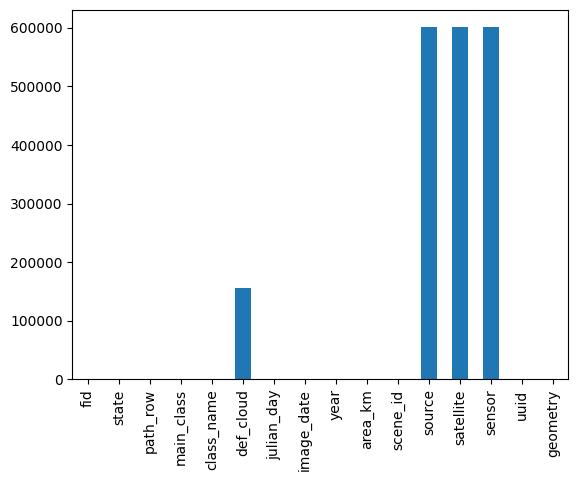

In [43]:
# visualize missing data
geo_yearly_deforestation_biome.isna().sum().plot.bar()

#### Clean and Merge
Drop columns that will not be useful in our model training (ie: state name) and those that are full of empty values.  Merge the columns from our state dataset with our time series dataset.

In [44]:
# drop columns we don't need
yearly_deforestation_clean = geo_yearly_deforestation_biome.drop(['main_class', 'class_name', 'def_cloud', 'julian_day', 'scene_id', 'source', 'satellite', 'sensor'], axis=1)

In [45]:
# merge state data in
yearly_deforestation_merged = yearly_deforestation_clean.merge(geo_states_amazon_merged, how='left', left_on='state', right_on='state')

In [46]:
yearly_deforestation_merged.sample(5)

,fid,state,path_row,image_date,year,area_km,uuid,geometry_x,id,nome,geocodigo,geometry_y,area,hydro_area,no_forest_area
442975,95610,AM,00166,2017-07-19,2017.0,0.296669,1074d9be-da34-4c49-bc10-5f62cefb719f,"POLYGON ((-66.54049 -9.37220, -66.53946 -9.372...",4,Amazonas,13,"POLYGON ((-73.79834 -7.11298, -73.79827 -7.112...",1.589484e+09,51077.536558,48506.459703
63739,615353,PA,22464,2017-07-29,2017.0,0.093151,8e87bce8-416e-4c1f-9b06-51ba3408b492,"POLYGON ((-49.90388 -5.69416, -49.90385 -5.694...",6,Pará,15,"MULTIPOLYGON (((-46.38414 -1.03655, -46.38429 ...",1.238830e+09,44115.717775,66845.300030
386863,37769,MA,22262,2009-08-10,2009.0,0.218833,aa26ecf3-43d6-4c49-9777-a4401e2233c5,"POLYGON ((-46.42041 -2.42624, -46.41906 -2.426...",26,Maranhão,21,"MULTIPOLYGON (((-44.08515 -2.41669, -44.08560 ...",1.137373e+08,4818.959857,8166.208790
91454,377693,PA,22562,2019-08-11,2019.0,0.008906,093876a8-3bf4-4b39-b823-f4d09df69217,"POLYGON ((-51.15248 -3.34614, -51.15208 -3.345...",6,Pará,15,"MULTIPOLYGON (((-46.38414 -1.03655, -46.38429 ...",1.238830e+09,44115.717775,66845.300030
126945,415195,PA,22564,2008-08-12,2008.0,0.140082,b15ca84d-c75e-4bde-a7b0-8f79f310c013,"POLYGON ((-51.98916 -5.54917, -51.98898 -5.549...",6,Pará,15,"MULTIPOLYGON (((-46.38414 -1.03655, -46.38429 ...",1.238830e+09,44115.717775,66845.300030


In [47]:
# clean up merged columns we don't need
yearly_deforestation_merged = yearly_deforestation_merged.drop(['nome', 'id', 'geocodigo', 'geometry_y'], axis=1)

In [48]:
yearly_deforestation_merged.sample(5)

,fid,state,path_row,image_date,year,area_km,uuid,geometry_x,area,hydro_area,no_forest_area
540327,196325,PA,22463,2017-07-29,2017.0,0.081934,2bf083c6-6ce5-4715-b6fb-05c5274e2e6c,"POLYGON ((-50.58661 -4.82015, -50.58652 -4.819...",1.238830e+09,44115.717775,66845.300030
660787,320987,PA,22765,2014-08-11,2014.0,0.101691,17394411-9807-4a46-a3f1-e268a24a91c1,"POLYGON ((-55.45666 -6.97702, -55.45612 -6.977...",1.238830e+09,44115.717775,66845.300030
278957,231804,MT,22967,2008-08-08,2008.0,0.079311,f18e0beb-3e49-46fe-86c3-79d535e6e2a0,"POLYGON ((-58.55086 -10.75782, -58.55059 -10.7...",5.130396e+08,1728.346000,45068.972799
428588,80606,PA,22463,2020-08-06,2020.0,0.132678,e1ccc00e-dd5b-4290-a9dc-8c515a987cf5,"POLYGON ((-50.44334 -4.92348, -50.44406 -4.926...",1.238830e+09,44115.717775,66845.300030
348597,607712,MT,23067,2016-07-20,2016.0,0.022372,696ed633-e8bb-4f30-9936-c91c403f0489,"POLYGON ((-60.06399 -9.95351, -60.06194 -9.953...",5.130396e+08,1728.346000,45068.972799


In [49]:
# cleanup column names
yearly_deforestation_merged = yearly_deforestation_merged.rename(columns={"area": "state_area", "geometry_x": "geometry", "hydro_area": "state_hydro_area", "no_forest_area": "state_no_forest_area", "area_km": "deforest_area_km"})

In [50]:
yearly_deforestation_merged.sample(5)

,fid,state,path_row,image_date,year,deforest_area_km,uuid,geometry,state_area,state_hydro_area,state_no_forest_area
58779,585599,PA,22562,2015-07-15,2015.0,0.000042,20f868a1-9e16-4742-9f31-9be6a7f7b448,"POLYGON ((-51.62994 -3.52979, -51.62987 -3.529...",1.238830e+09,44115.717775,66845.300030
509447,164145,AC,00565,2020-08-05,2020.0,0.339569,c85049c2-663d-4083-a3a3-2801c5d2fcd1,"POLYGON ((-73.02158 -7.71191, -73.02150 -7.711...",1.707994e+08,113.339475,70.051073
474342,127656,AM,23366,2019-08-03,2019.0,0.106198,a7811544-717c-4cab-9113-972027d2aa6d,"POLYGON ((-64.25798 -8.67196, -64.25710 -8.673...",1.589484e+09,51077.536558,48506.459703
603747,262134,MT,22667,2008-08-19,2008.0,0.118431,69b18ee0-9962-4d50-b321-66b99fca7527,"POLYGON ((-53.80554 -9.87604, -53.80554 -9.876...",5.130396e+08,1728.346000,45068.972799
171260,635934,PA,22562,2017-07-20,2017.0,0.000275,b4e61a93-89f9-4f8f-bb07-792722836ae5,"POLYGON ((-51.93733 -2.70799, -51.93733 -2.707...",1.238830e+09,44115.717775,66845.300030


In [51]:
# extract lat and long into discreet columns
yearly_deforestation_merged['lat'] = gpd.GeoSeries(yearly_deforestation_merged['geometry']).to_crs(epsg=4326).centroid.y
yearly_deforestation_merged['long'] = gpd.GeoSeries(yearly_deforestation_merged['geometry']).to_crs(epsg=4326).centroid.x
yearly_deforestation_merged.sample(5)

<ipython-input-51-52eb932b7d02>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  yearly_deforestation_merged['lat'] = gpd.GeoSeries(yearly_deforestation_merged['geometry']).to_crs(epsg=4326).centroid.y
<ipython-input-51-52eb932b7d02>:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  yearly_deforestation_merged['long'] = gpd.GeoSeries(yearly_deforestation_merged['geometry']).to_crs(epsg=4326).centroid.x


,fid,state,path_row,image_date,year,deforest_area_km,uuid,geometry,state_area,state_hydro_area,state_no_forest_area,lat,long
21531,622886,MT,22768,2019-08-09,2019.0,0.460373,48e3b58b-b28a-4dc7-b73d-24eed2868f82,"POLYGON ((-55.56103 -11.45333, -55.56400 -11.4...",5.130396e+08,1728.34600,45068.972799,-11.450856,-55.557585
249347,591826,MT,22968,2021-07-27,2021.0,0.161496,4ea1be86-b042-4efe-8e60-d93038d82617,"POLYGON ((-59.21726 -11.25528, -59.21698 -11.2...",5.130396e+08,1728.34600,45068.972799,-11.252105,-59.216052
106172,392890,MT,22968,2014-08-09,2014.0,0.071739,d93db710-ba01-47c4-ac5b-3d9f094ed7cb,"POLYGON ((-58.97841 -10.96065, -58.97626 -10.9...",5.130396e+08,1728.34600,45068.972799,-10.962210,-58.977610
298831,480064,RO,23168,2022-07-28,2022.0,0.161011,1eb21d47-e1af-4890-9f4c-4f2c996e996f,"POLYGON ((-62.47762 -11.60855, -62.48018 -11.6...",2.377802e+08,1766.08697,23295.406781,-11.606139,-62.479521
252577,595207,RO,23367,2014-08-21,2014.0,0.103489,25578763-a467-41a2-9193-cd611e99f2eb,"POLYGON ((-64.78693 -10.18377, -64.78677 -10.1...",2.377802e+08,1766.08697,23295.406781,-10.185266,-64.785780


In [52]:
yearly_deforestation_merged.sample(5)

,fid,state,path_row,image_date,year,deforest_area_km,uuid,geometry,state_area,state_hydro_area,state_no_forest_area,lat,long
270610,76755,MT,22467,2014-08-06,2014.0,0.119390,6886009c-d577-4e32-a128-c35620d95c5a,"POLYGON ((-51.30276 -9.86447, -51.30142 -9.864...",5.130396e+08,1728.346000,45068.972799,-9.866223,-51.302596
110358,397793,MT,22569,2013-07-25,2013.0,0.176810,c7ec399f-fb5c-4b0c-9cb3-b2bec6e9ef2d,"POLYGON ((-53.77918 -13.50043, -53.77918 -13.5...",5.130396e+08,1728.346000,45068.972799,-13.502054,-53.776967
187697,473723,RR,00158,2012-11-03,2012.0,0.071185,ca438bce-c067-4b3e-8968-5f84dcf2a3b6,"POLYGON ((-63.91847 2.57950, -63.91850 2.57950...",2.253429e+08,1753.155361,60902.109316,2.580042,-63.916297
269981,61178,RO,23068,2022-08-14,2022.0,0.112156,1bc1efe0-0ff5-4071-a486-769bd247308f,"POLYGON ((-61.57348 -11.63104, -61.57195 -11.6...",2.377802e+08,1766.086970,23295.406781,-11.631588,-61.570929
214754,562841,PA,22563,2016-02-24,2016.0,0.050969,532061fa-2187-4f77-8061-11017c975c41,"POLYGON ((-52.06693 -3.55283, -52.06693 -3.551...",1.238830e+09,44115.717775,66845.300030,-3.552863,-52.065705


## Clustering by lat/long
We will create clusters of detected deforestations to segment the data by more granular location than state.  These clusters will be used downstream in modeling to forecast new deforestation in each cluster area and new activity in each cluster (activity defined by unique count of deforestation activity).

DBSCAN is used due to its suitability to lat/lon geodata as outlined here:
https://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/

In [53]:
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint


In [124]:
# helper functions
def write_geojson(df, filename):
    df.to_file('/content/drive/MyDrive/USD/datasets/amazon_deforestation/' + filename, driver='GeoJSON')

In [58]:
# check for nulls in our lat/long
yearly_deforestation_merged.isna().sum()

fid                       0
state                     0
path_row                  0
image_date                0
year                      0
deforest_area_km          0
uuid                      0
geometry                435
state_area                0
state_hydro_area          0
state_no_forest_area      0
lat                     435
long                    435
dtype: int64

In [59]:
# drop samples with null lat/long
yearly_deforestation_merged = yearly_deforestation_merged.dropna()

In [60]:
# extract lat/long
coords = yearly_deforestation_merged[['lat', 'long']]

In [61]:
# setup cluster parameters and fit model
kms_per_radian = 6371.0088
epsilon = 4 / kms_per_radian # 4 km radius
db = DBSCAN(eps=epsilon, min_samples=7, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))


In [62]:
# show descriptive results
print('Number of clusters: {}'.format(num_clusters))
print('Cluster labels: {}'.format(cluster_labels))

Number of clusters: 2224
Cluster labels: [ 0  0  1 ... 20  9  9]


In [63]:
df = pd.DataFrame({'labels': cluster_labels})
df.value_counts()

labels
4         147229
1          59899
3          55359
10         41934
11         18365
           ...  
2191           4
2030           4
1838           4
2068           3
2167           2
Length: 2224, dtype: int64

In [64]:
# merge labels into main df
yearly_deforestation_merged['cluster'] = cluster_labels

In [65]:
# inspect results
yearly_deforestation_merged.sample(5)

,fid,state,path_row,image_date,year,deforest_area_km,uuid,geometry,state_area,state_hydro_area,state_no_forest_area,lat,long,cluster
578782,236083,PA,22464,2021-08-09,2021.0,0.968486,c23c2c13-4e03-4758-9633-658efbbb0388,"POLYGON ((-51.00276 -5.42689, -51.00201 -5.428...",1.238830e+09,44115.717775,66845.300030,-5.429073,-51.002892,4
87618,354630,PA,22463,2008-08-21,2008.0,0.063177,8eb60617-df0d-4801-9707-106b41ecd20c,"POLYGON ((-50.81044 -4.44412, -50.80969 -4.444...",1.238830e+09,44115.717775,66845.300030,-4.445329,-50.809927,4
38440,373308,RO,23268,2021-08-17,2021.0,0.062848,4d2dc782-9083-4060-8dbd-081c17b97de6,"POLYGON ((-63.67240 -12.32674, -63.67123 -12.3...",2.377802e+08,1766.086970,23295.406781,-12.327778,-63.673160,2
522744,177528,RR,23258,2014-08-30,2014.0,0.103161,d5db58e8-a5e2-4a00-9137-8feabfe986eb,"POLYGON ((-61.25280 3.23395, -61.25173 3.23395...",2.253429e+08,1753.155361,60902.109316,3.231287,-61.253733,63
637730,297103,PA,22762,2008-09-27,2008.0,0.083067,16edaeae-666b-4e1e-ab72-505f478116e5,"POLYGON ((-53.90309 -3.65837, -53.90255 -3.658...",1.238830e+09,44115.717775,66845.300030,-3.660194,-53.903309,3


In [66]:
# re-type into geopandas dataframe
yearly_deforestation_merged_geo = gpd.GeoDataFrame(yearly_deforestation_merged, geometry=yearly_deforestation_merged['geometry'])

In [67]:
# create a geopandas dataframe using only lat/long points for easier visualization
gdf_points = gpd.GeoDataFrame(yearly_deforestation_merged_geo, geometry=gpd.points_from_xy(yearly_deforestation_merged_geo.long, yearly_deforestation_merged_geo.lat))

## For each cluster, get the descriptive characteristics
For each cluster, we will calculate following and add as features:


1.   Total area as buffer that contains all points
2.   Non-forest area
3.   Hydrography area

For the latter two, a spatial intersection will be performed against the corresponding layer



In [71]:
# load checkpoint of dataset (so we don't have to re-run all preprocessing above)
#yearly_deforestation_merged_geo = gpd.read_file('/content/drive/MyDrive/USD/datasets/amazon_deforestation/yearly_deforestation_merged_4_7.geojson')

### Calculate the total area km**2 as buffer containing each cluster
Create a convex hull around the points in the cluster

---



In [72]:
# get convex hul of all clusters
chdf = yearly_deforestation_merged_geo.dissolve("cluster").convex_hull.reset_index().set_geometry(0)

In [104]:
# remove non cluster areas
chdf = chdf[chdf['cluster'] != -1]
chdf = chdf[chdf['area'] > 0]

In [105]:
chdf.sample(100)

,cluster,0,area
65,64,"POLYGON ((-61.07805 3.21730, -61.11206 3.23298...",62028.572554
1692,1691,"POLYGON ((-57.93210 -3.72164, -57.95455 -3.709...",30915.020813
536,535,"POLYGON ((-54.82307 -12.90539, -54.82772 -12.9...",101852.513809
1942,1941,"POLYGON ((-66.01035 -2.66642, -66.02052 -2.624...",19519.864064
1701,1700,"POLYGON ((-62.59960 3.23618, -62.59719 3.23893...",385.838390
...,...,...,...
1212,1211,"POLYGON ((-58.15587 -12.30426, -58.17943 -12.3...",26339.286324
900,899,"POLYGON ((-58.12301 -14.91946, -58.12899 -14.8...",27398.911430
919,918,"POLYGON ((-60.11518 -15.28306, -60.13809 -15.2...",98715.639906
64,63,"POLYGON ((-61.28939 3.22153, -61.32072 3.25810...",34506.659449


<Axes: >

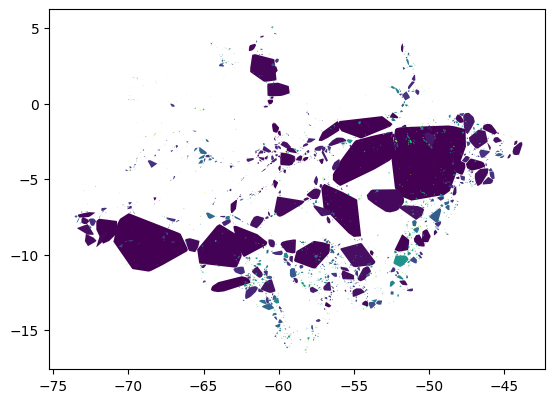

In [75]:
#plot to visualize
chdf.plot(column='cluster')

In [76]:
# calculate area of each cluster
chdf['area'] = gpd.GeoSeries(chdf[0]).to_crs(epsg=5880).area / 1000

In [77]:
# rename area col for easier merging
chdf.rename(columns={"area": "cluster_area"})

,cluster,0,cluster_area
1,0,"POLYGON ((-71.69929 -9.28168, -71.70096 -9.279...",2.220243e+07
2,1,"POLYGON ((-68.68226 -11.12957, -69.71596 -10.9...",1.542199e+08
3,2,"POLYGON ((-64.04438 -12.48888, -64.34218 -12.4...",1.853251e+07
4,3,"POLYGON ((-55.89982 -5.44488, -56.10895 -5.311...",1.019245e+08
5,4,"POLYGON ((-51.14377 -6.42367, -51.80825 -6.160...",2.513022e+08
...,...,...,...
2219,2218,"POLYGON ((-50.24237 -9.57677, -50.24663 -9.569...",8.465820e+03
2220,2219,"POLYGON ((-59.46238 -10.28257, -59.50524 -10.2...",2.400881e+03
2221,2220,"POLYGON ((-48.60584 -5.67125, -48.60415 -5.668...",7.282224e+03
2222,2221,"POLYGON ((-46.09459 -4.86260, -46.10394 -4.823...",1.654520e+04


In [80]:
yearly_deforestation_merged_geo

,fid,state,path_row,image_date,year,deforest_area_km,uuid,geometry,state_area,state_hydro_area,state_no_forest_area,lat,long,cluster
0,326676,AC,00466,2019-07-30,2019.0,0.306640,f7a2de5f-e537-40f2-b490-d856ccaba64f,POINT (-71.21497 -8.06395),1.707994e+08,113.339475,70.051073,-8.063950,-71.214971,0
1,326677,AC,00466,2018-07-27,2018.0,0.012968,7fc2df52-8a0f-489e-ac81-6e86e373e835,POINT (-71.22659 -8.06378),1.707994e+08,113.339475,70.051073,-8.063778,-71.226591,0
2,326678,AC,00267,2012-07-20,2012.0,0.080540,194ae734-7395-4bdc-81a6-5659d884b504,POINT (-67.57118 -10.10928),1.707994e+08,113.339475,70.051073,-10.109275,-67.571183,1
3,326679,AC,00167,2021-07-30,2021.0,0.171607,f98f0db9-eadd-4cce-b4cd-f611ecacdbca,POINT (-66.98262 -9.95968),1.707994e+08,113.339475,70.051073,-9.959678,-66.982621,1
4,326680,AC,00167,2021-07-30,2021.0,0.174035,799e7c70-bcdb-4f81-9ae1-1acbf5701d53,POINT (-66.98316 -9.96887),1.707994e+08,113.339475,70.051073,-9.968869,-66.983164,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
666299,326674,PA,22362,2011-07-25,2011.0,0.095459,c01d522c-1a3a-44a4-a18e-d0326496dfbd,POINT (-48.01852 -3.02816),1.238830e+09,44115.717775,66845.300030,-3.028162,-48.018523,4
666300,326675,AC,00267,2018-07-29,2018.0,0.260064,0ce8c227-f5c2-4a11-a926-42a587dd9ee4,POINT (-67.54685 -10.12749),1.707994e+08,113.339475,70.051073,-10.127487,-67.546850,1
666301,623460,AM,23161,2014-08-23,2014.0,0.325835,babc75b5-bbe4-47a3-bcc1-43517799ccdb,POINT (-59.91331 -1.82188),1.589484e+09,51077.536558,48506.459703,-1.821875,-59.913314,20
666302,609063,RO,23167,2015-09-11,2016.0,0.093802,98809a8d-c4c4-4619-ad6a-e3bd7017cf49,POINT (-62.30753 -9.41267),2.377802e+08,1766.086970,23295.406781,-9.412667,-62.307529,9


In [88]:
# reset index after cleanup
yearly_deforestation_merged_geo = yearly_deforestation_merged_geo.reset_index()

In [90]:
# build list of cluster areas to add to DF
cluster_areas = []
for i in range(len(yearly_deforestation_merged_geo)):
  cluster = yearly_deforestation_merged_geo['cluster'][i]
  if(cluster == -1):
    area = 0
  else:
    area = float(chdf[chdf['cluster'] == cluster]['area'])
  cluster_areas.append(area)

In [91]:
# add to main df
yearly_deforestation_merged_geo['cluster_area'] = cluster_areas

In [92]:
# inspect results
yearly_deforestation_merged_geo.sample(5)

,index,fid,state,path_row,image_date,year,deforest_area_km,uuid,geometry,state_area,state_hydro_area,state_no_forest_area,lat,long,cluster,cluster_area
66584,66647,618344,MT,22770,2009-08-29,2009.0,0.106627,02f2a23a-68be-42ff-b7f9-44adefcc0126,POINT (-57.24647 -14.32206),5.130396e+08,1728.346000,45068.972799,-14.322057,-57.246474,371,4.986326e+05
598780,599208,257532,PA,22362,2010-07-03,2010.0,0.137976,73e0157b-4873-4006-9e4e-389af06fa047,POINT (-48.73999 -2.89993),1.238830e+09,44115.717775,66845.300030,-2.899933,-48.739989,4,2.513022e+08
430979,431384,83488,PA,22661,2017-08-12,2017.0,0.025542,1aac9f1e-5b8d-48ad-b8a5-9b5cebb2b64d,POINT (-52.01366 -2.19304),1.238830e+09,44115.717775,66845.300030,-2.193038,-52.013664,4,2.513022e+08
515991,516403,171104,PA,22863,2009-08-20,2009.0,0.060229,e5c7766f-fffa-4d0a-a60f-c59af8ab39f2,POINT (-55.99165 -3.90105),1.238830e+09,44115.717775,66845.300030,-3.901046,-55.991647,181,2.793547e+06
404331,404731,55746,PA,22765,2020-07-26,2020.0,0.129776,3b858305-729d-4b4f-b298-3065dd16e427,POINT (-55.40563 -6.73203),1.238830e+09,44115.717775,66845.300030,-6.732032,-55.405633,11,6.581122e+07


### Calculate the total area km**2 that each cluster has intersecting with no_forest and hydrography layers
Create a convex hull around the points in the cluster

In [97]:
# clean geo forest df
geo_no_forest_biome = geo_no_forest_biome.dropna(subset=['geometry'])

In [106]:
# Performing overlay funcion
no_forest_cluster = geo_no_forest_biome.overlay(chdf, how='intersection')

<Axes: >

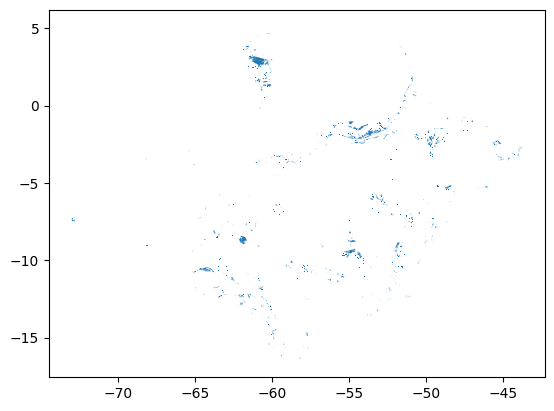

In [107]:
# visualize
no_forest_cluster.plot()

In [108]:
# Calculating the areas of the newly-created geometries
no_forest_cluster['area_joined'] = gpd.GeoSeries(no_forest_cluster['geometry']).to_crs(epsg=5880).area / 1000

In [110]:
# calculate area for each cluster
cluster_areas = no_forest_cluster.groupby('cluster')['area_joined'].sum().reset_index()

In [111]:
# build list of cluster areas to add to DF
cluster_no_forest_areas = []
for i in range(len(yearly_deforestation_merged_geo)):
  cluster = yearly_deforestation_merged_geo['cluster'][i]
  if(len(cluster_areas[cluster_areas['cluster'] == cluster]['area_joined']) == 0):
    area = 0
  else:
    area = float(cluster_areas[cluster_areas['cluster'] == cluster]['area_joined'])
  cluster_no_forest_areas.append(area)

In [112]:
# add to main df
yearly_deforestation_merged_geo['cluster_no_forest_area'] = cluster_no_forest_areas

### Do overlay to get hydrography area for each cluster

In [113]:
# cleanup items with no geometry
geo_hydrography_biome_clean = geo_hydrography_biome.dropna(subset=['geometry'])

In [114]:
geo_hydrography_biome_clean

,fid,state,path_row,main_class,class_name,def_cloud,julian_day,image_date,year,area_km,scene_id,source,satellite,sensor,uuid,geometry
5,761,AM,22962,HIDROGRAFIA,HIDROGRAFIA,0.0,0.0,None,2007.0,2.235277e+01,0.0,None,None,None,c7025230-2d26-42d8-8492-c950fbedd6fe,"POLYGON ((-57.40664 -3.17094, -57.40449 -3.170..."
6,828,AM,22962,HIDROGRAFIA,HIDROGRAFIA,0.0,0.0,None,2007.0,5.094973e+03,0.0,None,None,None,1a83d7d7-0ff8-49b7-bdc1-b64f5123ffc3,"POLYGON ((-58.14828 -2.86190, -58.14828 -2.862..."
7,1420,MT,22868,HIDROGRAFIA,HIDROGRAFIA,0.0,0.0,None,2007.0,3.992713e+01,0.0,None,None,None,39b550da-fcce-4c7c-8d59-838a8a00a260,"POLYGON ((-57.44656 -11.43543, -57.44619 -11.4..."
9,1535,AM,23062,HIDROGRAFIA,HIDROGRAFIA,0.0,0.0,None,2007.0,1.694353e+01,0.0,None,None,None,3ea9910e-df73-416d-9d23-c24128240ae2,"POLYGON ((-59.72383 -3.41600, -59.72356 -3.416..."
10,1790,AM,23061,HIDROGRAFIA,HIDROGRAFIA,0.0,0.0,None,2007.0,4.498570e+02,0.0,None,None,None,aad17522-c823-4f20-9479-82fa9e340290,"POLYGON ((-59.40250 -2.04894, -59.40211 -2.048..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32012,32013,MA,22062,HIDROGRAFIA,HIDROGRAFIA,NaN,NaN,None,NaN,9.135927e-07,NaN,amazon biome outside the legal amazon,Landsat,OLI,dca0d23c-47a2-4f04-b67e-9c71427272f2,"POLYGON ((-43.90883 -2.55854, -43.90884 -2.558..."
32013,32014,MA,22062,HIDROGRAFIA,HIDROGRAFIA,NaN,NaN,None,NaN,8.075018e-04,NaN,amazon biome outside the legal amazon,Landsat,OLI,d6040383-c13c-4497-b713-62ee71b0254b,"POLYGON ((-43.94756 -3.38867, -43.94759 -3.388..."
32014,32015,MA,22062,HIDROGRAFIA,HIDROGRAFIA,NaN,NaN,None,NaN,9.532101e-03,NaN,amazon biome outside the legal amazon,Landsat,OLI,dc7a9cb1-8433-40ee-82a4-13845312eb11,"POLYGON ((-43.96226 -2.92865, -43.96216 -2.928..."
32015,32016,MA,22062,HIDROGRAFIA,HIDROGRAFIA,NaN,NaN,None,NaN,3.915154e-09,NaN,amazon biome outside the legal amazon,Landsat,OLI,b9a3f7e5-a2e4-48aa-9071-24f0cfeb36cf,"POLYGON ((-43.99111 -2.81592, -43.99111 -2.815..."


In [115]:
# Performing overlay funcion
hydrography_cluster = geo_hydrography_biome_clean.overlay(chdf, how='intersection')

<Axes: >

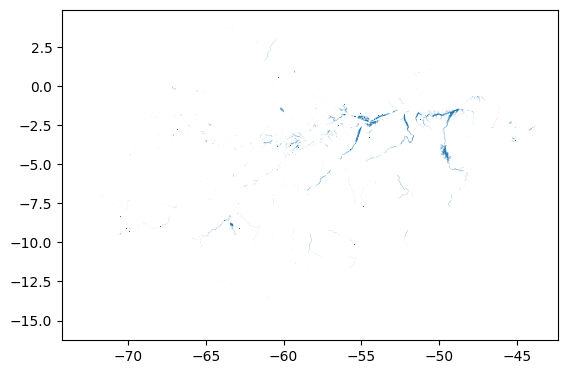

In [116]:
# visualize the intersection
hydrography_cluster.plot()

In [117]:
# Calculating the areas of the newly-created geometries
hydrography_cluster['area_joined'] = gpd.GeoSeries(hydrography_cluster['geometry']).to_crs(epsg=5880).area / 1000

In [119]:
# calculate area for each cluster
cluster_hydro_areas = hydrography_cluster.groupby('cluster')['area_joined'].sum().reset_index()

In [120]:
# build list of cluster areas to add to DF
cluster_hydrography_areas = []
for i in range(len(yearly_deforestation_merged_geo)):
  cluster = yearly_deforestation_merged_geo['cluster'][i]
  if(len(cluster_hydro_areas[cluster_hydro_areas['cluster'] == cluster]['area_joined']) == 0):
    area = 0
  else:
    area = float(cluster_hydro_areas[cluster_hydro_areas['cluster'] == cluster]['area_joined'])
  cluster_hydrography_areas.append(area)

In [121]:
# add to main df
yearly_deforestation_merged_geo['cluster_hydro_area'] = cluster_hydrography_areas

In [125]:
# store a checkpoint of points
write_geojson(yearly_deforestation_merged_geo, 'yearly_deforestation_merged_cluster_meta.geojson')

## Normalize and Encode Features
To make the data ingestible by our model, we need to normalize all the continuous variables and one-hot encode the categorical features.


#### Normalize numeric values with min-max scaling
Use min-max scaler from scikit-learn to scale the numeric values (area values) to 0-1 values making it easier for our models to work with

In [ ]:
yearly_deforestation_merged_copy = yearly_deforestation_merged.copy()

In [ ]:
# initialize scaler
scaler = MinMaxScaler()

In [ ]:
# Normalize numeric area columns with min/max scaling
yearly_deforestation_merged[['deforest_area_km','state_area', 'state_hydro_area', 'state_no_forest_area']] = scaler.fit_transform(yearly_deforestation_merged[['deforest_area_km','state_area', 'state_hydro_area', 'state_no_forest_area']])

In [ ]:
yearly_deforestation_merged.sample(5)

#### One hot encode state column


In [ ]:
# get one hot encodings
dummies = pd.get_dummies(yearly_deforestation_merged['state'], prefix='state')
dummies

In [ ]:
#merge back into df
yearly_deforestation_merged = pd.concat([yearly_deforestation_merged, dummies], axis=1)

In [ ]:
# inspect
yearly_deforestation_merged.sample(5)